## Optimization with a priori unknown constraints

If we are optimizing for some experiment, the planner needs a way to deal with possible infeasible areas. This may be due to instrumentation limits, or perhaps unmeasureable recommendations. For example, a synthesis reaction may fail, and it would not be possible to produce a yield measurement for a particular set of reagents. 

The default approach is the naive approach, which simply puts in a bad score for the infeasible point. More advanced *feasibility-aware* acqusition functions are available in Atlas. The details are mostly unchanged, only requiring a few additional arguments.

More details are provided in the manuscript; here we use the feasibility classifier acquisition (FCA).

In [17]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np

from olympus import Campaign, Surface
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.pyplot as plt
from atlas.unknown_constraints.benchmark_functions import BraninConstr
from atlas.planners.gp.planner import GPPlanner


sns.set(style='ticks', context='notebook', font_scale=1.2)
from cmcrameri import cm

In [18]:
## helper functions
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])

cmap = cm.nuuk

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap=cmap):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap=cmap) #'golem'
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    y_feas = np.array(surface.eval_constr(X))
    Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
    ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
        
def plot_constr_surface_with_scatter(ax, surface, data, repeat=0):

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    plot_constr_surface(surface, ax=ax, N=100)

    repeat = 0
    X = data[repeat].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    # mask = np.array([surface.is_feasible(x) for x in X])
    X_feas = X[mask]
    X_infs = X[~mask]

    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)

    

We begin the optimization here. We use the Branin-Hoo function with constraints. The constraints are designed to cover some of the local minima, so that really, there is only a single feasible minima that the BO surrogate should aim to find.

In [11]:
BUDGET = 100
NUM_INIT_DESIGN = 10

In [12]:
# load the constrained branin surface
# there are regions that are infeasible
surface = BraninConstr()
all_runs = []

campaign = Campaign() 
campaign.set_param_space(surface.param_space)

planner = GPPlanner(
    goal='minimize',
    feas_strategy='fca',        # feasibility strategy
    feas_param=0.2,             # parameter used by the strategy
    acquisition_type='ucb',
    acquisition_optimizer_kind='pymoo',
) # instantiate Atlas planner


planner.set_param_space(surface.param_space)
while len(campaign.observations.get_values()) < BUDGET:
    samples = planner.recommend(
        campaign.observations
    )  # ask planner for parameters (list of ParameterVectors)
    for sample in samples:
        measurement = surface.run_constr(sample)  # measure constrained Branin-Hoo function
        campaign.add_observation(
            sample, measurement
        )  # tell planner about most recent observation

x0_col = campaign.observations.get_params()[:, 0]
x1_col = campaign.observations.get_params()[:, 1]

df = pd.DataFrame({
    'x0': x0_col,
    'x1': x1_col,
    'obj': campaign.observations.get_values()
})


Plotting the recommendations on the constrained surface, we see that the method successfully avoids the regions of infeasibility (the circular shaded area), and finds the optimum that is still feasible.

We also plot the best value as well.

Text(0.5, 1.0, 'Best value found in BO')

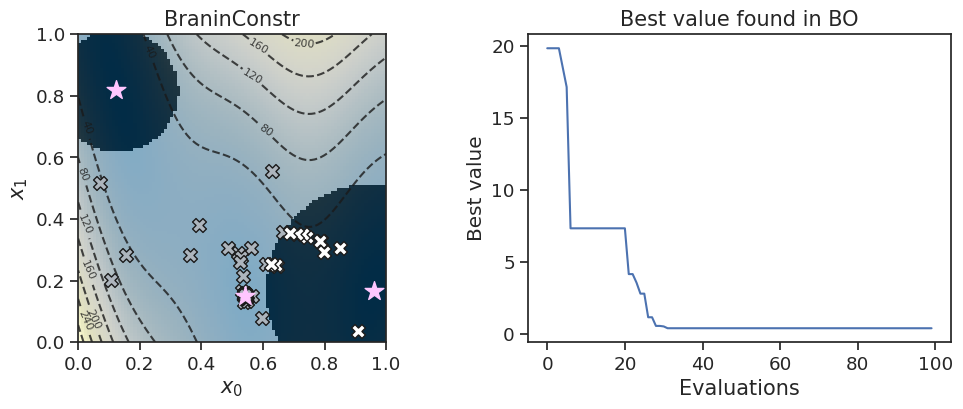

In [24]:
# process the dataframe
df['Best value'] = df['obj'].cummin()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# surface with observations
plot_constr_surface_with_scatter(axes[0], surface, [df], repeat=0)
axes[0].set_xlabel(r'$x_0$', fontsize=15)
axes[0].set_ylabel(r'$x_1$', fontsize=15)
axes[0].set_title('BraninConstr', fontsize=15)

sns.lineplot(data=df, x=df.index, y='Best value')
axes[1].set_xlabel(r'Evaluations', fontsize=15)
axes[1].set_title('Best value found in BO', fontsize=15)

